In [2]:
from scipy.special import roots_jacobi, eval_jacobi
import numpy as np
import scipy
import math

In [3]:
import matplotlib.pyplot as plt

### Initialization:

In [88]:
L = 12 # Denotes total length in [0, L]
M = 4 # Denotes number of elements 
x_range = np.arange(0, L + (L/M), (L/M)) # Define the element endpoints

In [79]:
x_range

array([ 0.,  3.,  6.,  9., 12.])

In [4]:
def int_points(x_range, npts, dx, M):
    
    k = 0
    p_order = npts - 1
    xinterior, w = roots_jacobi(p_order - 1,1,1) # returns interior GLL nodes from range -1 and 1
    GLL_points = np.pad(xinterior, (1, 1), 'constant', constant_values=(-1, 1))
    GLL_dist = np.array([np.abs(GLL_points[0] - value) for value in GLL_points])
    
    return_array = np.zeros([M, npts])
    
    for i in x_range[:-1]:
        array = np.array([i])
        for j in GLL_dist[1:]: 
            scaled_point = ((j / 2) * (dx)) + i # Note: 2 here is the distance from -1 to 1
            array = np.concatenate((array, np.array([scaled_point])))
            
        return_array[k, :] = array
        k = k + 1
    
    return(return_array)

In [5]:
def init_Guassian(input_array, mu, sigma): 
    
    return_array = np.zeros_like(input_array)
    
    for i in np.arange(input_array.shape[0]):
        
        numerator = np.exp(-(input_array[i] - mu)**2 / (2 * sigma**2))
        denominator = sigma * np.sqrt(2 * np.pi)
        return_array[i, :] = numerator / denominator 
        
    return(return_array)

In [6]:
def Guassian_1st_deriv(input_array, mu, sigma):
    return(-(input_array - mu) / sigma**2 * init_Guassian(input_array, mu, sigma))

## Apply Derivative Operator to Elements:

In [11]:
def vandermonde(npts_values, return_type):
    # For the monomial basis: 
    if return_type == 'Monomial':
        return(np.vander(npts_values, increasing = True))
    elif return_type == 'Legendre':
        return(np.polynomial.legendre.legvander(npts_values, len(npts_values) - 1))

In [12]:
def Ld_vandermonde(npts_values): 
    
    LP = np.polynomial.legendre
    v_matrix = np.polynomial.legendre.legvander(npts_values, len(npts_values)-1)
    d_v_matrix = np.zeros_like(v_matrix)

    for i in range(len(npts_values)):
        # Coefficients for the i-th Legendre polynomial (e.g., [0, 0, 1] for P_2)
        coeffs = np.zeros(len(npts_values))
        coeffs[i] = 1

        # Compute the derivative of the i-th Legendre polynomial
        deriv_coeffs = LP.legder(coeffs, m=1) # m=1 for first derivative

        # Evaluate the derivative at the points x
        d_v_matrix[:, i] = LP.legval(npts_values, deriv_coeffs)
        
    return(d_v_matrix)

In [13]:
def Md_vandermonde(npts_values):
    
    v_matrix = np.vander(npts_values, increasing = True)
    d_v_matrix = np.zeros_like(v_matrix)
    
    for i in range(len(npts_values) - 1):
        coeffs = np.zeros(len(npts_values))
        coeffs[i] = i + 1
        
        deriv_P = np.polynomial.polynomial.Polynomial(coeffs) 
        d_v_matrix[:, i + 1] = deriv_P(npts_values)
        
    return(d_v_matrix)

In [14]:
def return_D(V1, V2):
    return(np.matmul(V2, np.linalg.inv(V1)))

### Compute Derivative Matrix:

In [15]:
# Note: the nodal inputs are all within the reference element:

npts = 4
p_order = npts - 1
xinterior, w = roots_jacobi(p_order - 1,1,1) # returns interior GLL nodes from range -1 and 1
GLL_points = np.pad(xinterior, (1, 1), 'constant', constant_values=(-1, 1))

V1 = vandermonde(GLL_points, 'Legendre')
V2 = Ld_vandermonde(GLL_points)
D = return_D(V1, V2)

In [16]:
# Note: L, M are constants; D denotes the derivative matrix computed above:

def deriv_elements(D, value_array, L, M):
    
    return_array = np.zeros_like(value_array)
    
    for i in np.arange(M): 
        d_values = np.matmul(D, value_array[i].transpose())
        return_array[i] = (d_values * ((2 * M) / L)) # Multiply by factor: (2M / L)
        
    return(return_array)

In [17]:
deriv_values = deriv_elements(D, init_Guassian(int_points(x_range, 4, L/M, M), (L/2), 1), 
                              L, M)

deriv_values

array([[ 0.00120991, -0.00071833,  0.00238983,  0.00815997],
       [-0.06530813,  0.12627456,  0.18789814,  0.07248638],
       [-0.07248638, -0.18789814, -0.12627456,  0.06530813],
       [-0.00815997, -0.00238983,  0.00071833, -0.00120991]])

### Quick Plotting:

In [24]:
def plot_FEM(int_points, value_array, M):
    
    fig = plt.plot()
    
    for i in np.arange(M):
        plt.plot(int_points[i], value_array[i], marker = 'o')
        # plt.plot(fine_int_points[i], fine_value_array[i])

    return()

def plot_FEM_ic(int_points, value_array, M):
     
    for i in np.arange(M):
        plt.plot(int_points[i], value_array[i], marker = '*', color = 'green')
        # plt.plot(fine_int_points[i], fine_value_array[i])

    return()

[]

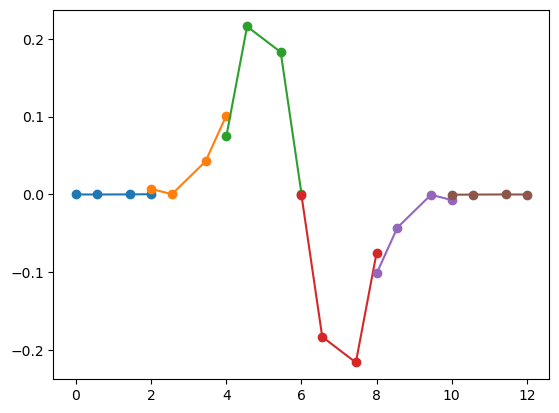

In [17]:
plot_FEM(int_points(x_range, 4, L/M, M), deriv_values, M)
         # int_points(x_range, 25, L/M, M), Guassian_1st_deriv(int_points(x_range, 25, L/M, M), (L/2), 1))


In [140]:
x_range = np.arange(0, L + (L/M), (L/M)) # Define the element endpoints

In [174]:
# Note: The num_pts variable is for each element; written for Legendre basis
def dV_multi_finegrid(x_range, n_order, num_pts, deriv_values):
    
    hold = 0
    LP = np.polynomial.legendre
    dv_finegrid = np.zeros([num_pts * (len(x_range) - 1), n_order])
    
    for i, j in enumerate(x_range[:-1]):
        # dx = np.diff(x_range)[0] / (num_pts) # Assuming element lengths are all equal 
        dx = (1/5)
        npts = np.arange(j, x_range[i+1], dx)
     
        for k in np.arange(n_order):
            coeffs = np.zeros(n_order)
            coeffs[k] = 1
            
            deriv_coeffs = LP.legder(coeffs, m=1)
        
            # We need to calculate (LP'(x) * LP^-1(x)): 
            d_P = LP.legval(npts, deriv_coeffs)
            P = np.polynomial.legendre.Legendre(coeffs)
            
            dv_finegrid[hold : hold + (num_pts), k] = (d_P / P(npts))
            
        hold = hold + num_pts
        
    return(dv_finegrid)

In [ ]:
dV_multi_finegrid(x_range, 4, 10, deriv_values)

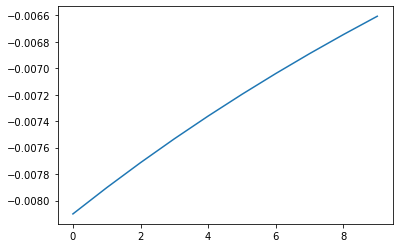

In [145]:
plt.plot(np.arange(0, 10), np.matmul(elem_4, deriv_values[4].transpose()))

### CG Boundary Averaging:

In [24]:
def boundary_mean(value_array, M):
    
    return_array = value_array.copy()
     
    for i in np.arange(M-1):
        mean_value = np.mean([value_array[i][-1], value_array[i+1][0]])
        return_array[i][-1] = mean_value
        return_array[i+1][0] = mean_value 
        
    # For the endpoints:
    return_array[-1][-1] = np.mean([value_array[-1][-1], value_array[0][0]])
    return_array[0][0] = np.mean([value_array[-1][-1], value_array[0][0]])
        
    return(return_array)

In [19]:
test = boundary_mean(deriv_values, M)

[]

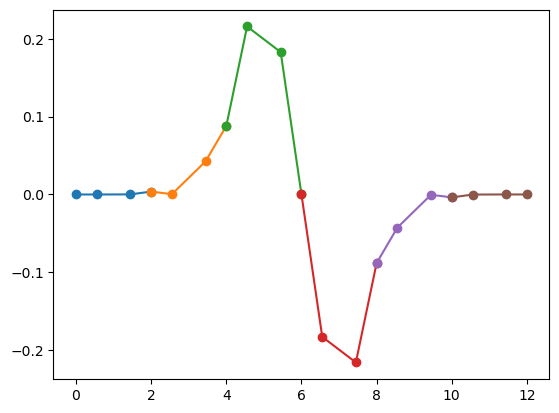

In [20]:
plot_FEM(int_points(x_range, 4, L/M, M), test, M)
         # int_points(x_range, 25, L/M, M), Guassian_1st_deriv(int_points(x_range, 25, L/M, M), (L/2), 1))

### Applied to 1D Advection (with Predictor-Corrector Method):

In [15]:
# Initialize the elements and the Guassian function:

L = 12 # Denotes total length in [0, L]
M = 4 # Denotes number of elements 
x_range = np.arange(0, L + (L/M), (L/M)) # Define the element endpoints

npts = 4
p_order = npts - 1
xinterior, w = roots_jacobi(p_order - 1,1,1) # returns interior GLL nodes from range -1 and 1
GLL_points = np.pad(xinterior, (1, 1), 'constant', constant_values=(-1, 1))

# GLL_points = [-1, 1]
# Note: The D matrix is only created once as it operates on the reference element
V1 = vandermonde(GLL_points, 'Legendre')
V2 = Ld_vandermonde(GLL_points)
D = return_D(V1, V2)

# The following is used in creating the init condition: 
npts = int_points(x_range, 4, L/M, M)
# npts = np.array([[x_range[i], x_range[i + 1]] for i in np.arange(len(x_range) - 1)])

In [16]:
npts

array([[ 0.        ,  0.82917961,  2.17082039,  3.        ],
       [ 3.        ,  3.82917961,  5.17082039,  6.        ],
       [ 6.        ,  6.82917961,  8.17082039,  9.        ],
       [ 9.        ,  9.82917961, 11.17082039, 12.        ]])

In [25]:
# Compute the derivative matrix:
def SEM_dx(D, u, M, L):
    
    u_out = np.zeros_like(u)
    
    for j in np.arange(npts.shape[0]):
        u_out[j] = (np.matmul(D, u[j].transpose()) * ((2 * M) / L))
        
    return(boundary_mean(u_out, M))

In [26]:
t_steps = 12
dt = 0.10

u = init_Guassian(npts, (L/2), 1)

for i in np.arange(0, t_steps, dt):
    
    u_mid = np.zeros_like(u)
    u_n = np.zeros_like(u)
    
    # Half time step:
    u_mid = u - ((dt / 2) * SEM_dx(D, u, M, L))
    # Full time step:
    u_n = u - ((dt) * SEM_dx(D, u_mid, M, L))
    
    # Prepare for the next timestep:
    u = u_n

In [27]:
u

array([[-0.04796433,  0.02177871,  0.01388166, -0.0428971 ],
       [-0.0428971 ,  0.04040688,  0.28244533,  0.37306751],
       [ 0.37306751,  0.29033937,  0.05559084, -0.02030702],
       [-0.02030702, -0.00376252, -0.00039902, -0.04796433]])

Text(0.5, 1.0, 'IC & FEM Solution at t_step: 12')

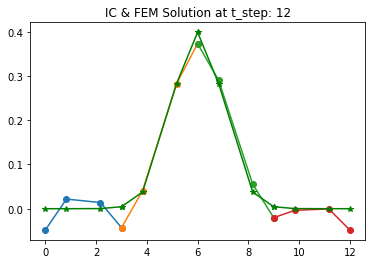

In [507]:
plot_FEM(npts, u, M)
plot_FEM_ic(npts, init_Guassian(npts, (L/2), 1), M)
plt.title('IC & FEM Solution at t_step: 12')

()

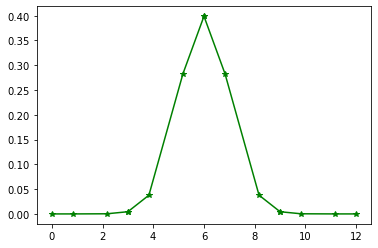

In [508]:
plot_FEM_ic(npts, init_Guassian(npts, (L/2), 1), M)

### Property Check -> Integration by Parts:

In [17]:
# Note: Quad weights only needs to defined for one element as all elements use the same functional space
# The weights are calculated using exact integration 

def quad_weights(npts_values):
    
    # Values in f_array result from exact integration:
    f_array = np.zeros(len(npts_values))
    f_array[0] = 2
    
    # Define basis matrix for Legendre polynomials: 
    V = np.polynomial.legendre.legvander(npts_values, len(npts_values) - 1).transpose()
    
    return(np.matmul(np.linalg.inv(V), f_array.transpose()))

In [510]:
p_order = 3
xinterior, w = roots_jacobi(p_order - 1,1,1) # returns interior GLL nodes from range -1 and 1
GLL_points = np.pad(xinterior, (1, 1), 'constant', constant_values = (-1, 1))

quad_weights(GLL_points)

array([0.16666667, 0.83333333, 0.83333333, 0.16666667])

In [511]:
# Note: Ensure u is a nested array for M elements 

def quad_int(u, L, M, quad_weights):
    
    return_array = np.zeros(M)
    
    for i in np.arange(M):
        return_array[i] = (np.sum(u[i] * quad_weights)) * (L / (2 * M))
        
    return(np.sum(return_array))

### Test 1: Check int(1) = L

In [512]:
def int_test(input_array): 
    
    return_array = np.zeros_like(input_array)
    for i in np.arange(input_array.shape[0]):
        return_array[i, :] = 1 
        
    return(return_array)

quad_int(int_test(npts), L, M, quad_weights(GLL_points))

11.999999999999998

### Test 2: Mass Conservation

In [513]:
u1 = (quad_int(init_Guassian(npts, (L/2), 1), L, M, quad_weights(GLL_points)))
u2 = (quad_int(u, L, M, quad_weights(GLL_points)))

u1, u2

(1.0063010876099612, 1.0063010876099612)

### Test 3: Integration by Parts

In [438]:
# P1 = np.polynomial.polynomial.Polynomial([1, 2, 3])
# P2 = np.polynomial.polynomial.Polynomial([12, 14, 18])

def define_poly(input_array):
    
    P1_out = np.zeros_like(input_array)
    P2_out = np.zeros_like(input_array)
    
    for i in np.arange(input_array.shape[0]):
        P1_out[i] = np.sin(2 * np.pi * (input_array[i]))
        P2_out[i] = 3 * np.sin(2 * np.pi * (input_array[i]))
        
    return(P1_out, P2_out)

In [439]:
V = vandermonde(GLL_points, 'Legendre')
D = return_D(V, Ld_vandermonde(GLL_points))
f, q = define_poly(int_points(x_range, 4, L/M, M))

()

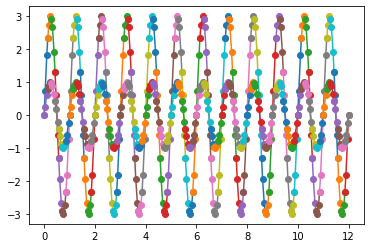

In [442]:
plot_FEM(int_points(x_range, 4, L/M, M), boundary_mean(q, M), M)
plot_FEM(int_points(x_range, 4, L/M, M), boundary_mean(f, M), M)

In [443]:
I1 = quad_int(SEM_dx(D, boundary_mean(f, M), L, M) * q, L, M, quad_weights(GLL_points))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 2)

In [138]:
I2 = quad_int(SEM_dx(D, boundary_mean(q, M), L, M) * f, L, M, quad_weights(GLL_points))

In [142]:
I1 + I2

-3.4842749758448737e-14

### DG Implementation:

In [18]:
def centered_boundary_mean(value_array, M):
    
    return_array = value_array.copy()
     
    for i in np.arange(M-1):
        mean_value = np.mean([value_array[i][-1], value_array[i+1][0]])
        return_array[i][-1] = mean_value
        return_array[i+1][0] = mean_value 
        
    # For the endpoints:
    return_array[-1][-1] = np.mean([value_array[-1][-1], value_array[0][0]])
    return_array[0][0] = np.mean([value_array[-1][-1], value_array[0][0]])
        
    return(return_array)

In [19]:
def weighted_boundary_mean(value_array, M, array):
    
    # Note: Sum of w_array should be 1; adjust w_array for upwind direction
    
    return_array = value_array.copy()
     
    for i in np.arange(M-1):
        mean_value = (array[0] * value_array[i][-1]) + (array[1] * value_array[i+1][0])
        return_array[i][-1] = mean_value
        return_array[i+1][0] = mean_value 
        
    # For the endpoints:
    return_array[-1][-1] = (array[0] * value_array[-1][-1]) + (array[1] * value_array[0][0])
    return_array[0][0] = (array[0] * value_array[-1][-1]) + (array[1] * value_array[0][0])
        
    return(return_array)

In [20]:
# Compute the derivative matrix:
def DG_SEM_dx(D, u, M, L, w_array):
    
    u_out = np.zeros_like(u)
    # Adjusted for upwinded flux:
    u_mean = centered_boundary_mean(u, M)
    
    for j in np.arange(M):
        u_out[j] = (np.matmul(D, u[j].transpose()) * ((2 * M) / L))
        
        # Add DG boundary terms:
        
        # Left boundary:
        u_out[j][0] = u_out[j][0] - ((u_mean[j][0] - u[j][0]) / (w_array[0] * (L / (2 * M))))
        # Right boundary: 
        u_out[j][-1] = u_out[j][-1] + ((u_mean[j][-1] - u[j][-1]) / (w_array[-1] * (L / (2 * M))))
        
    return(u_out)

In [21]:
t_steps = 12
dt = 0.10

u = init_Guassian(npts, (L/2), 1)

for i in np.arange(0, t_steps, dt):
    
    u_mid = np.zeros_like(u)
    u_n = np.zeros_like(u)
    
    # Half time step:
    u_mid = u - ((dt / 2) * DG_SEM_dx(D, u, M, L, quad_weights(GLL_points)))
    # Full time step:
    u_n = u - ((dt) * DG_SEM_dx(D, u_mid, M, L, quad_weights(GLL_points)))
    
    # Prepare for the next timestep:
    u = u_n

In [23]:
u.reshape(-1)

array([ 0.088567  , -0.02167252, -0.0776931 ,  0.04841133,  0.04698194,
        0.12319314,  0.24800313,  0.30239349,  0.29467319,  0.29250982,
        0.09871945, -0.02156745, -0.0234518 , -0.07653663,  0.05353969,
        0.08888182])

Text(0.5, 1.0, 'IC & DG FEM Solution at t_step: 12')

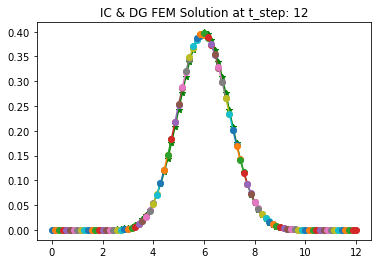

In [422]:
plot_FEM_ic(npts, init_Guassian(npts, (L/2), 1), M)
plot_FEM(npts, u, M)

plt.title('IC & DG FEM Solution at t_step: 12')

### Test 1: Mass Conservation

In [423]:
u1 = (quad_int(init_Guassian(npts, (L/2), 1), L, M, quad_weights(GLL_points)))
u2 = (quad_int(u, L, M, quad_weights(GLL_points)))

u1, u2

(0.9999999979041997, 0.9999999979041999)

### Test 2: Integration by Parts:

In [497]:
def define_pw_poly(input_array):
    
    arr_1 = [1, 3, 5, 7]
    arr_2 = [2, 4, 6, 8]
    
    P1_out = np.zeros_like(input_array)
    P2_out = np.zeros_like(input_array)
    
    for i in np.arange(input_array.shape[0]):
        P1_out[i] = input_array[i] + arr_1[i]
        P2_out[i] = input_array[i] + arr_2[i]
        
    return(P1_out, P2_out)

In [499]:
T1, T2 = define_pw_poly(npts)
T3 = T1 * T2

In [500]:
np.sum(np.array([(T3[i][-1] - T3[i][0]) for i in np.arange(M)]))

252.0

In [501]:
I1 = quad_int(deriv_elements(D, T1, L, M) * T2, L, M, quad_weights(GLL_points))
I2 = quad_int(deriv_elements(D, T2, L, M) * T1, L, M, quad_weights(GLL_points))

I1 + I2

252.00000000000003

### Test 3: Monotonicity Check:

In [519]:
u = np.zeros_like(npts)
u[1] = 1
u[2] = 1

In [520]:
t_steps = 12
dt = 0.10

# u = init_Guassian(npts, (L/2), 1)

for i in np.arange(0, t_steps, dt):
    
    u_mid = np.zeros_like(u)
    u_n = np.zeros_like(u)
    
    # Half time step:
    u_mid = u - ((dt / 2) * DG_SEM_dx(D, u, M, L, quad_weights(GLL_points)))
    # Full time step:
    u_n = u - ((dt) * DG_SEM_dx(D, u_mid, M, L, quad_weights(GLL_points)))
    
    # Prepare for the next timestep:
    u = u_n

()

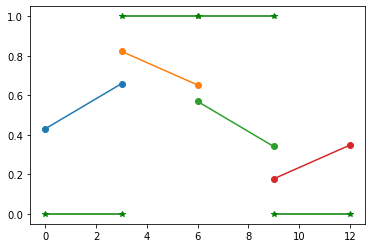

In [522]:
u_init = np.zeros_like(npts)
u_init[1] = 1
u_init[2] = 1

plot_FEM_ic(npts, u_init, M)
plot_FEM(npts, u, M)

In [521]:
M

4